# Big Data Analysis Project - Group Project FS2020
## University of Zurich
## 5th of June 2020

Jara Fuhrer, 15-702-889

Claudio Brasser,

Severin Siffert, 14-720-536

Andrea Giambonini, 10-726-842

Elizabeth Oladipo, 17-722-414


## "The goal of the project is to apply the data science pipeline"

![title](doingDS.png)

# Data Collection / Acquisition

Our dataset comes from http://www.kave.cc/, where 15'000 hours of interaction data from Visual Studio was collected in almost 11 million events from voluntaries.
To see what kind of data is collected, you can look at the data schema here: http://www.kave.cc/feedbag/event-generation.

Within this project, we focus on three events:
- build event: actions like build, build all, or clean
- edit event: changes made by the developer, like renaming
- test run event: which tests where run when and with what result


# Data Exploration

#### Who constructed data set, when, why?
The KaVE Project originally was a German research program. Over the past 10 years, it evolved into a platform for research around recommendation systems for software engineering. Generally, they're interested in questions like how humans influence software engineering or how certain tools can support humans to better / more efficiently perform their tasks. 
Examples are intelligent code completion, interaction trackers or evaluation tools.

The KaVE are collecting and providing these data sets such that we can better understand what software engineers do / what they interact with / where their problems lie. With this data, we can try to see relations betweek the workign behaviour of developers (edit events, time, run test and results of them) and his efficienty / performance / productivity / habits /...

Below, the three data sets we extracted from the gigantic pile of possibilities are explained.

#### What do we want to learn from this data?
From personal experience, we know how important it is to frequently build your code and run some tests. Only then you're able to link what you've done (i.e. what you've written, the edit events) to the outcome (i.e. (hopefully) working code, build and test run events). 

* often repeated advice: compile early, compile often
* intuition: longer time between tests/builds = more chance to screw up
* Is there a way to show that empirically?

Our goal of this data analysis therefore is to analyze the link between the probability of Unit tests or project builds succeeding in connection with how much time has passed since the last build/test run.


#### Hypotheses
TODO --> how did we get to this hypos?

* we want to test the advice 'compile early, compile often' and the closely related 'test a lot' empirically
* found relevant events in the data: edit (code modified), build and test events

Our hypotheses are:

1) the longer a developer waits to build his code, the higher the probability that the build will fail

2) the longer a developer waits to run some tests, the higher the probability for test failures

3) the more edit events a developer executes, the lower the probability that the build will succeed

4) the more edit events a developer executes, the lower the probability for test success



#### Final Data Analysis Questions:
1) linking time since last (successful?) build to probability of build succeeding -- SEVERIN

2) linking time since last tests run to probability of tests passing -- ELIZABETH

3) linking number of edit events since last successful build to probability of build succeeding -- ANDREA

4) linking number of edit events since last passing tests to probability of unit tests passing -- JARA


In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from itertools import islice
from sklearn import datasets, linear_model
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


C:\Users\Sev\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.linear_model.stochastic_gradient module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df_edit = pd.read_csv("../data/df_edit.csv")
editEvents = df_edit
df_test = pd.read_csv("../data/df_test.csv")
testEvents = df_test
df_build = pd.read_csv("../data/df_build.csv")
buildEvents = df_build

## TODO JARA: Short description of the data frames & their columns

* first, a walkthrough about what data we actually extracted from the huge pile of events
* three categories: edit, build, test

### Edit Events

* edit event = code was modified
 * typing
 * copy/paste
 * auto generating getter/setter
 * other refactoring
* sessionID see data cleaning

In [4]:
df_edit.iloc[:,1:3]

,sessionID,timestamp
0,0,2016-10-04 14:36:01
1,0,2016-10-04 14:36:07
2,0,2016-10-04 14:36:49
3,0,2016-10-04 14:36:53
4,1,2016-10-04 14:37:03
...,...,...
497454,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:48
497455,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:52
497456,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:58
497457,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:14:03


The first column is the index of the dataframe.

The second column includes the sessionID.

The third colum is the timestamp of the edit event.

In total, we got 2876 unique sessionIDs for which in total 497'459 edit events have been recorded.

In [5]:
df_edit["timestamp"].describe() 
 

count                  497459
unique                 488049
top       2016-09-04 23:31:53
freq                        4
Name: timestamp, dtype: object

In [6]:
df_edit["sessionID"].describe()

count                                   497459
unique                                    2876
top       8d0ea603-57cd-4b1f-b3cf-ce39ec9203c7
freq                                     17006
Name: sessionID, dtype: object

### Test Events

In [7]:
df_test.iloc[:,1:5]

,sessionID,timestamp,totalTests,testsPassed
0,006eb9aa-33f1-4e9e-8e74-7c978b58ee4a,2016-05-03 09:32:16,33,33
1,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:18,1,0
2,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:21:54,26,26
3,03c83bf2-8938-4a8f-9f58-d52bf3b2eccd,2016-05-10 17:28:26,1,1
4,0504fbd1-cce2-4431-b4e2-edc63eea1c6d,2016-07-13 20:24:46,21,21
...,...,...,...,...
3821,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:57:23,1,0
3822,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:04:16,1,0
3823,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:05:03,1,0
3824,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:23:52,1,1


In [8]:
df_test.describe()

,Unnamed: 0,totalTests,testsPassed
count,3826.000000,3826.000000,3826.000000
mean,1912.500000,88.780972,76.577627
std,1104.615393,430.785770,392.217908
min,0.000000,-1.000000,-1.000000
25%,956.250000,1.000000,0.000000
50%,1912.500000,3.000000,1.000000
75%,2868.750000,21.000000,15.000000
max,3825.000000,6618.000000,6090.000000


The first column is the index of the dataframe.

The second column includes the sessionID.

The third colum is the timestamp of the edit event.

The fourth column includes the total number of tests run at this specific time.

And the firth column states how many tests actually passed.

### Build Events

In [9]:
df_build.iloc[:,1:4]

,sessionID,timestamp,buildSuccessful
0,0,2016-10-04 14:35:55,False
1,0,2016-10-04 14:36:07,False
2,0,2016-10-04 14:36:50,False
3,0,2016-10-04 14:36:53,False
4,1,2016-10-04 14:37:03,True
...,...,...,...
14952,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:04:17,True
14953,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:05:05,True
14954,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:23:53,True
14955,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:24:13,True


In [10]:
df_build.describe()

,Unnamed: 0
count,14957.000000
mean,7478.000000
std,4317.858323
min,0.000000
25%,3739.000000
50%,7478.000000
75%,11217.000000
max,14956.000000


# Data Preprocessing / Cleaning

The data was originally available in individual json events, with great support for parsing with Java or C#. Since we have to work with python, we used Java to convert the relevant information into csv without cleaning the data first.

* remove wrong data
* parse timestamps
* split into sessions

<i> --> TODO Claudio </i>

# Model / Algorithm Building

- chapter 6
- we should agree on some basics
- fit model with optimization methods?
- linear vs non-linear, blackbox vs descriptive, first principle vs data driven, stochastic vs deterministic, flat vs hierarchical
- model evaluation: trianign data set, validation data set, test data set
- classifiers, value prediction, absolute / relative / squared error, baseline models?

In [11]:
grouped = df_edit.groupby(['sessionID'])
sessionStarts = grouped.agg({'timestamp':np.min}).to_dict()

## Predicting Build success

* first investigation: how likely is a build to succeed
* hypothesis: longer time or more edits between builds = less probability of build succeeding

### Predicting Build success by time since last build

* first up: prepare data
 * starting points for sessions
 * time since last build

### Predicting build success by number of edit events

* Step: For each sessionID:
 - get timestamp of the last successfull build
 - get timestamp of next build after a)
* Step: For each session ID:
 - Count number of edit between the two timestamp in Step 1
 - if no buildEvent after last successfull build occurs, dont count
* Step: Create new DataFrame with following variables:
 - sessionID,timestampSuccessBuild, timestampNextBuild, #editsUntilNextBuild and nextBuildResult



In [15]:
def get_all_build(sessionID):
    all_build = buildEvents[buildEvents["sessionID"] == sessionID]
    return all_build.sort_values(["timestamp"]).values

In [16]:
def get_successful_build(sessionID):
    all_successful_build = buildEvents[(buildEvents["sessionID"] == sessionID) & (buildEvents["buildSuccessful"] == True)] 
    return all_successful_build.sort_values(["timestamp"]).values

In [17]:
def get_nr_edits_between_build(sessionID,timeLastSuccessfullBuild, timeNextBuild):
    totalEdit = editEvents[editEvents["sessionID"] == sessionID]
    totalEdit = totalEdit.sort_values(["timestamp"])
    editBetweenSuccessBuildAndBuild = totalEdit[(totalEdit["timestamp"] <= timeNextBuild) & (totalEdit["timestamp"] >= timeLastSuccessfullBuild)]
    return editBetweenSuccessBuildAndBuild["timestamp"].values.size

In [18]:
def edits_from_pass_to_next_build(sessionID):
    result = []

    # get all successful build of session 
    allSuccessfulBuild = get_successful_build(sessionID)
    allBuild = get_all_build(sessionID)
    numOfSuccessfulBuild = np.size(allSuccessfulBuild,0)
    numOfBuild = np.size(allBuild,0)
    # iterate over each passed build
    for s in range(numOfSuccessfulBuild):
        # if build follows, count edits
        if allBuild[-1][2]>allSuccessfulBuild[s][2]:
            for b in range(numOfBuild):
                if allBuild[b][2]>allSuccessfulBuild[s][2]:
                    break
            timeLastSuccessfulBuild=allSuccessfulBuild[s][2]
            timeNextBuild=allBuild[b][2]
            resultNextBuild=allBuild[b][3]
            nrOfEdit=get_nr_edits_between_build(sessionID,timeLastSuccessfulBuild, timeNextBuild)
            sessionID = allBuild[b][1]
            time_passed = pd.Timedelta(datetime.strptime(timeNextBuild, '%Y-%m-%d %H:%M:%S')-datetime.strptime(timeLastSuccessfulBuild, '%Y-%m-%d %H:%M:%S')).seconds
            
            result.append([sessionID, timeLastSuccessfulBuild, timeNextBuild, time_passed, nrOfEdit, resultNextBuild])
            
    return result

#### Iterate over all sessions and create DataFrame

In [19]:
final_result=[]
allSessionID=buildEvents.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    Observations = edits_from_pass_to_next_build(sessionID)
    NrOfObservations = len(Observations)
    # take only sessionID with at least 1 successful build and at least 1 build after that  
    if NrOfObservations > 0:
        for Obs in Observations:
            final_result.append(Obs)
print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-05-29 14:59:50.369834 

time after loop: 2020-05-29 15:09:47.185782 



In [20]:
#create DataFrame
column_labels = ['sessionID','timestampSuccessBuild','timestampNextBuild','time_passed', '#editsUntilNextBuild', 'nextBuildResult']
df = pd.DataFrame(final_result, columns=column_labels)
df

,sessionID,timestampSuccessBuild,timestampNextBuild,time_passed,#editsUntilNextBuild,nextBuildResult
0,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 09:27:01,2016-11-10 10:22:32,3331,5,True
1,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:22:32,2016-11-10 10:58:26,2154,16,True
2,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:58:26,2016-11-10 11:07:58,572,18,True
3,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:07:58,2016-11-10 11:37:53,1795,38,True
4,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:37:53,2016-11-10 11:41:29,216,8,True
...,...,...,...,...,...,...
11584,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:53:44,2016-06-14 14:57:24,220,6,True
11585,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:57:24,2016-06-14 15:04:17,413,39,True
11586,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:04:17,2016-06-14 15:05:05,48,3,True
11587,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:05:05,2016-06-14 15:23:53,1128,43,True


#### Create model

In [21]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
import statsmodels.tools.tools as sm
import statsmodels.api as sm1
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE

In [22]:
df.isnull().any()

sessionID                False
timestampSuccessBuild    False
timestampNextBuild       False
time_passed              False
#editsUntilNextBuild     False
nextBuildResult          False
dtype: bool

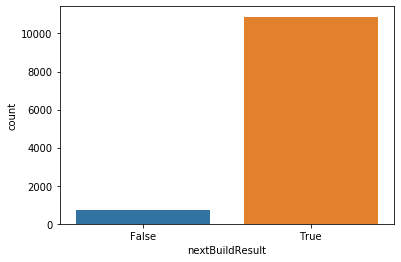

only 6.1% of the build-events fail


In [23]:
sns.countplot(x="nextBuildResult",data=df)
plt.show()
count_failedBuild = len(df[df["nextBuildResult"]==False])
count_passedBuild = len(df[df["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'only {pct_failedBuild}% of the build-events fail')

In [41]:
df.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","median","max"]})

#editsUntilNextBuild                        
                               count       mean median   max
nextBuildResult                                             
False                            710  43.074648     13  3838
True                           10879  18.572663      7  2330

In [44]:
df.groupby("nextBuildResult").agg({"time_passed":["count","mean","median","max"]})

time_passed                           
                      count         mean median    max
nextBuildResult                                       
False                   710  2986.767606  239.5  85892
True                  10879  1408.183105  115.0  86196

* Our classes (successful vs. fail Build events) are strongly imbalanced.
* The average number of edits between the last successful Build and the next Build event is more then twice as much for fail Build as for successful Build.
* Average and median time since the last build is also more than double for failed builds
* Median times of roughly 120 and 240 seconds between builds suggest surprisingly frequent builds happening. Based on our own experience we thought these numbers would be at least twice as high.


Let's do some more exploration


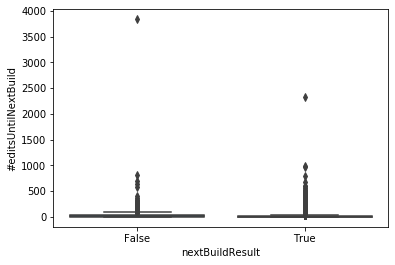

In [25]:
sns.boxplot(x=df["nextBuildResult"], y=df["#editsUntilNextBuild"])

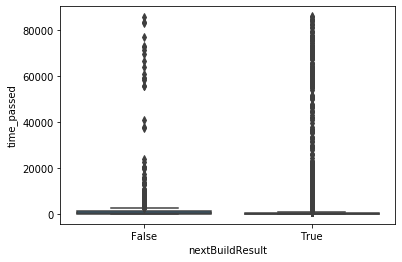

In [45]:
sns.boxplot(x=df["nextBuildResult"], y=df["time_passed"])



There might be outlier in the dataset. We might want to keep only observation with at most 200? 75? edits between Build event


In [32]:
df1=df.loc[(df["#editsUntilNextBuild"]>0) & (df["#editsUntilNextBuild"]<200)]
df1.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","median","max"]})

#editsUntilNextBuild                       
                               count       mean median  max
nextBuildResult                                            
False                            686  27.360058     12  198
True                           10755  15.428266      7  199

In [33]:
df2=df.loc[(df["#editsUntilNextBuild"]>0) & (df["#editsUntilNextBuild"]<75)]
df2.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","median","max"]})

#editsUntilNextBuild                      
                               count       mean median max
nextBuildResult                                           
False                            621  17.175523     10  73
True                           10411  12.137931      7  74

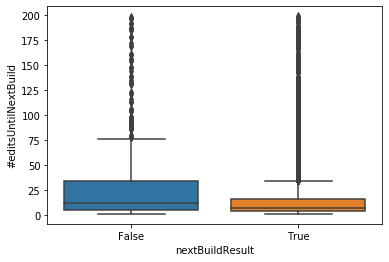

In [28]:
sns.boxplot(x=df1["nextBuildResult"], y=df1["#editsUntilNextBuild"])

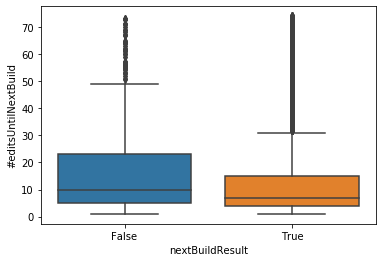

In [29]:
sns.boxplot(x=df2["nextBuildResult"], y=df2["#editsUntilNextBuild"])

Based on the same reasoning of removing outliers we cut build intervals over 60 minutes.

In [49]:
df3=df.loc[(df["time_passed"]>0) & (df["time_passed"]<3600)]
df3.groupby("nextBuildResult").agg({"time_passed":["count","mean","median","max"]})

time_passed                         
                      count        mean median   max
nextBuildResult                                     
False                   630  520.852381  174.5  3552
True                  10353  298.326089  103.0  3588

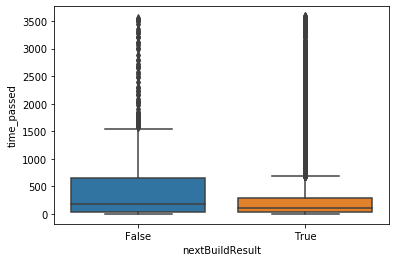

In [50]:
sns.boxplot(x=df3["nextBuildResult"], y=df3["time_passed"])

In [51]:
print(f'{round(len(df3)/len(df)*100,1)}% of all observation has a number of edits between Build events lower than 200 and took less than 1 hour of coding')

94.8% of all observation has a number of edits between Build events lower than 200 and took less than 1 hour of coding


(0, 100)

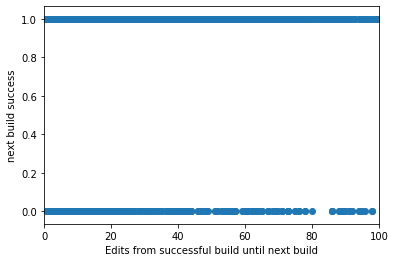

In [35]:
plt.scatter(df["#editsUntilNextBuild"],df["nextBuildResult"])
plt.xlabel("Edits from successful build until next build")
plt.ylabel("next build success")
plt.xlim(0,100)

Logistic Model:

Goal: predict the probability of the categorical dependent variable (i.e. success or failure of the Build-Event). \ The logistic regression predicts P(Y=success) as a function of X (nr. of edits).

In [54]:
Y = df3["nextBuildResult"]
X = df3[["#editsUntilNextBuild",'time_passed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.215514
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        nextBuildResult   No. Observations:                10983
Model:                          Logit   Df Residuals:                    10980
Method:                           MLE   Df Model:                            2
Date:                Fri, 29 May 2020   Pseudo R-squ.:                 0.01881
Time:                        15:39:44   Log-Likelihood:                -2367.0
converged:                       True   LL-Null:                       -2412.4
Covariance Type:            nonrobust   LLR p-value:                 1.979e-20
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.0422      0.050     60.777      0.000       2.944       3.140

The coefficient of 'time_passed' is not statistical significant (at 90% significant level) and therefore we will remove it.

In [57]:
Y = df3["nextBuildResult"]
X = df3["#editsUntilNextBuild"]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.216564
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        nextBuildResult   No. Observations:                10983
Model:                          Logit   Df Residuals:                    10981
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 May 2020   Pseudo R-squ.:                 0.01402
Time:                        15:40:19   Log-Likelihood:                -2378.5
converged:                       True   LL-Null:                       -2412.4
Covariance Type:            nonrobust   LLR p-value:                 1.938e-16
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9800      0.048     62.662      0.000       2.887       3.073

As we saw in the data exploration part. Our dataset is strong imbalanced. Let's try to balance the dataset!

In [58]:
os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X1, Y, test_size=0.1,random_state=0)

os_data_X, os_data_Y = os.fit_sample(X_train,Y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=['constant','#editsUntilNextBuild'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("length of oversampled data is", len(os_data_X))
print("Number of failed Build in oversampled data", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X))

logit_model=sm1.Logit(os_data_Y,os_data_X)
result_logit=logit_model.fit()
print(result_logit.summary2())

length of oversampled data is 18626
Number of failed Build in oversampled data 9313
Number of successful Build 9313
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5


MissingDataError: exog contains inf or nans

In [59]:
#Y = df1["nextBuildResult"]
#X = df1[["#editsUntilNextBuild",'time_passed']].values
#X_train, X_test, y_train, y_test = model_selection.train_test_split(os_data_X.values, os_data_Y, test_size=0.1,random_state=0)
#X_test=sm.add_constant(X_test)
logit_model=linear_model.LogisticRegression()
logit_model.fit(os_data_X, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model.score(X_test,Y_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
Y_pred = logit_model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test,Y_pred)
print(confusion_matrix)
print(metrics.classification_report(Y_test,Y_pred))

The coefficient for the nr. of edits is statistical significant and the number of edits seems to have a negative effect on the probability of a successful build. However the Pseudo R-squared of this logistical regression is very small. This leads us to think that there might be other (omitted) variables that have a much greater influence on the probability of successful build events.

## Successful Tests percentage

### Time since last tests run

In [ ]:
# gets all passed tests for sessionID
def get_passed_tests(sessionID):
    allPassedTests = testEvents[(testEvents["sessionID"] == sessionID) 
                        & (testEvents["testsPassed"] > 0)]
    return np.asarray(allPassedTests)

# counts the numbers of edits between a test and the next test
# for our purpose, be aware to only call it with passed tests
def get_nr_edits_between_tests(sessionID, timeFirstTest , timeNextTest):
    result = editEvents[(editEvents["timestamp"] < timeNextTest)
                                 & (editEvents["timestamp"] > timeFirstTest) 
                                 & (editEvents["sessionID"] == sessionID)]
    result = np.asarray(result)
    return len(result)

In [ ]:
# counts nr of edits from passed test until next test event
# returns a list
def edits_from_pass_to_next_test(sessionID):
    result = []
    resultRow = []
    # get all passed tests of the session 
    allPassedTests = get_passed_tests(sessionID)

    numOfRows = np.size(allPassedTests, 0)
    # iterate over each passed test
    for p in range(numOfRows):
        timePass = allPassedTests[p][2]

        # no following test
        if p == numOfRows-1:
            hasNextTest = False
        else:
            hasNextTest = True
            timeTestNext = allPassedTests[p+1][2]
            resultNext = allPassedTests[p+1][4]

        # for each passed test, get nr of edits until next test
        if hasNextTest:
            nrOfEdits = get_nr_edits_between_tests(sessionID,timePass, timeTestNext)
            print(f'time of pass to append: {timePass}')
            print(f'nr of edits: {nrOfEdits}')
            print(f'result next: {resultNext} \n')
            result.append([sessionID, timePass, timeTestNext, nrOfEdits, resultNext])
            
    return result

In [ ]:
# creates a DF with 8 columns
def create_df(resultArray):
    print(f'Length result: {len(resultArray)} \n\n')

    # Create DataFrame
    column_labels = ['sessionID','timePass','timeNext', 'editsUntilNextTest', 'ratio P/T','totalTestsNext', 'testPassedNext' ,'booleanNextTest']
    df = pd.DataFrame(resultArray, columns=column_labels)
    return df;

#### Iterate over sessions and create DF

In [ ]:
# Creates a DF and returns a list that contains among other things
# the nr of edits from a passing test until the next test event and whether this next test has been successful
def get_edits_tests_list():
    sessionWithPassedTests=0
    sessionWithoutPassedTests=0
    sessionWithPassedTestsButNoNextTest=0
    result=[]
    print(f'time before loop: {datetime.now(tz=None)} \n')
    for index, row in testEvents.iterrows():
        if(row["testsPassed"] > 0):
            sessionWithPassedTests+=1
            #has next test
            if((index+1 < len(testEvents)) and (testEvents.iloc[index+1].sessionID == row["sessionID"])):
                item=[]
                timestampNext=testEvents.iloc[index+1].timestamp
                totalTestsNext=testEvents.iloc[index+1].totalTests
                passedTestNext=testEvents.iloc[index+1].testsPassed
                nrOfEdits=get_nr_edits_between_tests(row["sessionID"], row["timestamp"], timestampNext)
                if(passedTestNext == 0):
                    resultTestNextBoolean = 0
                else:
                    resultTestNextBoolean = 1
                if(totalTestsNext != 0):
                    ratioPT = (passedTestNext/totalTestsNext)
                else:
                    ratioPT = 0
                item.append(row["sessionID"])
                item.append(row["timestamp"])
                item.append(timestampNext)
                item.append(nrOfEdits)
                item.append(float(ratioPT))
                item.append(int(totalTestsNext))
                item.append(int(passedTestNext))
                item.append(int(resultTestNextBoolean))
                result.append(item)
            else:
                sessionWithPassedTestsButNoNextTest+=1
        else:
            sessionWithoutPassedTests+=1
    print(f'with passed: {sessionWithPassedTests}')
    print(f'with passed test but no next test: {sessionWithPassedTestsButNoNextTest}')
    print(f'without passed test: {sessionWithoutPassedTests}')
    print(f'total: {sessionWithoutPassedTests+sessionWithPassedTests}')
    print(f'time after loop and df: {datetime.now(tz=None)} \n')
    
    print(result[0])
    print(result[1])
    print(result[2])

    
    return result

In [ ]:
edits_tests= get_edits_tests_list()

In [ ]:
create_df(edits_tests)

In [ ]:
#calculate avg 
print(len(edits_tests))
edits_tests_array = np.asarray(edits_tests, dtype='O')
nrEventsTest = edits_tests_array[:, 4:6]
nrOfEvents = edits_tests_array[:,3]
testPass = edits_tests_array[:,4]

#sort ascending to nr of events
nrEventsTestSorted = sorted(nrEventsTest, key=lambda entry: entry[0]) 

#chunk size 200 = 12 chunks
chunkSize = math.ceil(int(len(nrOfEvents))/200)
print(f'chunk size: {chunkSize}')

chunk1, chunk2, chunk3, chunk4, chunk5, chunk6, chunk7, chunk8, chunk9, chunk10,chunk11, chunk12 = np.array_split(nrEventsTestSorted, chunkSize)
print(f'first chunk len: {len(chunk1)}')
print(f'last chunk len: {len(chunk12)}')

fails=[]
fails.append(np.count_nonzero(chunk1[:,1] == 0))
fails.append(np.count_nonzero(chunk2[:,1] == 0))
fails.append(np.count_nonzero(chunk3[:,1] == 0))
fails.append(np.count_nonzero(chunk4[:,1] == 0))
fails.append(np.count_nonzero(chunk5[:,1] == 0))
fails.append(np.count_nonzero(chunk6[:,1] == 0))
fails.append(np.count_nonzero(chunk7[:,1] == 0))
fails.append(np.count_nonzero(chunk8[:,1] == 0))
fails.append(np.count_nonzero(chunk9[:,1] == 0))
fails.append(np.count_nonzero(chunk10[:,1] == 0))
fails.append(np.count_nonzero(chunk11[:,1] == 0))
fails.append(np.count_nonzero(chunk12[:,1] == 0))
print(fails)

passList=[]
passList.append(np.count_nonzero(chunk1[:,1] == 1))
passList.append(np.count_nonzero(chunk2[:,1] == 1))
passList.append(np.count_nonzero(chunk3[:,1] == 1))
passList.append(np.count_nonzero(chunk4[:,1] == 1))
passList.append(np.count_nonzero(chunk5[:,1] == 1))
passList.append(np.count_nonzero(chunk6[:,1] == 1))
passList.append(np.count_nonzero(chunk7[:,1] == 1))
passList.append(np.count_nonzero(chunk8[:,1] == 1))
passList.append(np.count_nonzero(chunk9[:,1] == 1))
passList.append(np.count_nonzero(chunk10[:,1] == 1))
passList.append(np.count_nonzero(chunk11[:,1] == 1))
passList.append(np.count_nonzero(chunk12[:,1] == 1))

print(passList)

In [ ]:
edits_tests_array = np.asarray(edits_tests)

nrOfEvents = edits_tests_array[:,3]
testPass = edits_tests_array[:,4]
start = max(nrOfEvents)
end = min(nrOfEvents)


#plot 1
fig, ax = plt.subplots()
ax.scatter(nrOfEvents, testPass)
plt.xlabel('nr of events from passed test until next test')
plt.ylabel('nr of passed tests')
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(5))
#yaxis
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()


#plot 3
df = create_df(edits_tests)
df.groupby(['editsUntilNextTest','booleanNextTest']).size().unstack().plot(kind='bar',stacked=True)

#### Build model regression

In [ ]:
df_edit_tests = create_df(edits_tests)
grouped = df_edit_tests.groupby(['sessionID'])
sessionStarts = grouped.agg({'timePass':np.min}).to_dict()

In [ ]:
edits_tests_array = np.array(edits_tests, dtype="O")
edits_ratio_array = edits_tests_array[:,3:5]
edits_ratio_list = edits_ratio_array.tolist()
x = edits_tests_array[:,3]
y = edits_tests_array[:,4]
print(type(x[2]))
print(type(y[2]))

frame = pd.DataFrame(edits_ratio_list, columns=['edits','success'])
print(frame.head(20))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
def analyze_classifiers(x,y):
    classifiers = [('linear',SGDClassifier()),
                   ('logistic',LogisticRegression()),
                   ('knn',KNeighborsClassifier(3))]
    for name,model in classifiers:
        accuracies = []
        kf = KFold(n_splits=5,shuffle=True)
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit = model.fit(x_train, y_train)
            accuracies.append(accuracy_score(y_test, model.predict(x_test), normalize=True))
        print('accuracy of',name, 'is',np.mean(accuracies))

In [ ]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

# Data Visualization

- we should agree on some basic design / plots such that we have a consistent viz